In [1]:
import cv2
import matplotlib.pyplot as plt

In [5]:
import cv2


def captch_ex(file_name):
    img = cv2.imread(file_name)

    img_final = cv2.imread(file_name)
    img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 180, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)
    ret, new_img = cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY)  # for black text , cv.THRESH_BINARY_INV
    '''
            line  8 to 12  : Remove noisy portion 
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,
                                                         3))  # to manipulate the orientation of dilution , large x means horizonatally dilating  more, large y means vertically dilating more
    dilated = cv2.dilate(new_img, kernel, iterations=9)  # dilate , more the iteration more the dilation

    # for cv2.x.x

    _, contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # findContours returns 3 variables for getting contours

    # for cv3.x.x comment above line and uncomment line below

    #image, contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)


    for contour in contours:
        # get rectangle bounding contour
        [x, y, w, h] = cv2.boundingRect(contour)

        # Don't plot small false positives that aren't text
        if w < 35 and h < 35:
            continue

        # draw rectangle around contour on original image
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)

        '''
        #you can crop image and send to OCR  , false detected will return no text :)
        cropped = img_final[y :y +  h , x : x + w]

        s = file_name + '/crop_' + str(index) + '.jpg' 
        cv2.imwrite(s , cropped)
        index = index + 1

        '''
    # write original image with added contours to disk
    cv2.imshow('captcha_result', img)
    plt.imshow(img)
    plt.show()

file_name = '/Users/jinghuang/Desktop/Projects/Name Tents Recogitions/01.jpg'
captch_ex(file_name)

ValueError: not enough values to unpack (expected 3, got 2)

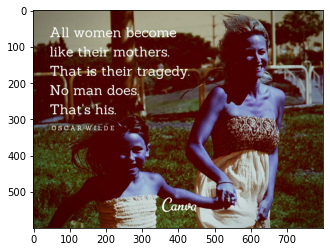

In [3]:
img = cv2.imread('01.jpg')
plt.imshow(img)
plt.show()
    


In [6]:
# Import required modules
import cv2 as cv
import math
import argparse

parser = argparse.ArgumentParser(description='Use this script to run text detection deep learning networks using OpenCV.')
# Input argument
parser.add_argument('--input', help='Path to input image or video file. Skip this argument to capture frames from a camera.')
# Model argument
parser.add_argument('--model', default="frozen_east_text_detection.pb",
                    help='Path to a binary .pb file of model contains trained weights.'
                    )
# Width argument
parser.add_argument('--width', type=int, default=320,
                    help='Preprocess input image by resizing to a specific width. It should be multiple by 32.'
                   )
# Height argument
parser.add_argument('--height',type=int, default=320,
                    help='Preprocess input image by resizing to a specific height. It should be multiple by 32.'
                   )
# Confidence threshold
parser.add_argument('--thr',type=float, default=0.5,
                    help='Confidence threshold.'
                   )
# Non-maximum suppression threshold
parser.add_argument('--nms',type=float, default=0.4,
                    help='Non-maximum suppression threshold.'
                   )

parser.add_argument('--device', default="cpu", help="Device to inference on")


args = parser.parse_args()


############ Utility functions ############
def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

if __name__ == "__main__":
    # Read and store arguments
    confThreshold = args.thr
    nmsThreshold = args.nms
    inpWidth = args.width
    inpHeight = args.height
    model = args.model

    # Load network
    net = cv.dnn.readNet(model)
    if args.device == "cpu":
        net.setPreferableBackend(cv.dnn.DNN_TARGET_CPU)
        print("Using CPU device")
    elif args.device == "gpu":
        net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)
        print("Using GPU device")


    # Create a new named window
    kWinName = "EAST: An Efficient and Accurate Scene Text Detector"
    cv.namedWindow(kWinName, cv.WINDOW_NORMAL)
    outputLayers = []
    outputLayers.append("feature_fusion/Conv_7/Sigmoid")
    outputLayers.append("feature_fusion/concat_3")

    # Open a video file or an image file or a camera stream
    cap = cv.VideoCapture(args.input if args.input else 0)

    while cv.waitKey(1) < 0:
        # Read frame
        hasFrame, frame = cap.read()
        if not hasFrame:
            cv.waitKey()
            break

        # Get frame height and width
        height_ = frame.shape[0]
        width_ = frame.shape[1]
        rW = width_ / float(inpWidth)
        rH = height_ / float(inpHeight)

        # Create a 4D blob from frame.
        blob = cv.dnn.blobFromImage(frame, 1.0, (inpWidth, inpHeight), (123.68, 116.78, 103.94), True, False)

        # Run the model
        net.setInput(blob)
        output = net.forward(outputLayers)
        t, _ = net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())

        # Get scores and geometry
        scores = output[0]
        geometry = output[1]
        [boxes, confidences] = decode(scores, geometry, confThreshold)
        # Apply NMS
        indices = cv.dnn.NMSBoxesRotated(boxes, confidences, confThreshold,nmsThreshold)
        for i in indices:
            # get 4 corners of the rotated rect
            vertices = cv.boxPoints(boxes[i[0]])
            # scale the bounding box coordinates based on the respective ratios
            for j in range(4):
                vertices[j][0] *= rW
                vertices[j][1] *= rH
            for j in range(4):
                p1 = (vertices[j][0], vertices[j][1])
                p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
                cv.line(frame, p1, p2, (0, 255, 0), 2, cv.LINE_AA)
                # cv.putText(frame, "{:.3f}".format(confidences[i[0]]), (vertices[0][0], vertices[0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv.LINE_AA)

        # Put efficiency information
        cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

        # Display the frame
        cv.imshow(kWinName,frame)
        cv.imwrite("output.png",frame)

usage: ipykernel_launcher.py [-h] [--input INPUT] [--model MODEL]
                             [--width WIDTH] [--height HEIGHT] [--thr THR]
                             [--nms NMS] [--device DEVICE]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/jinghuang/Library/Jupyter/runtime/kernel-2f60cc49-36ca-474b-b514-7b3cb7a71378.json


SystemExit: 2

/Users/jinghuang/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
